In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

import seaborn as sns
import matplotlib.ticker as ticker
import json
# Set style
# plt.style.use("seaborn-v0_8-whitegrid")

# Increase default font size and line width
plt.rcParams.update({'axes.labelsize': 20, 'axes.titlesize': 20, 'legend.fontsize': 20,
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'lines.linewidth': 2.5, 'lines.markersize': 10})


In [3]:
def read_wandb_log(root_dir, version=0):
    path = os.path.join(
        root_dir,
        'lightning_logs', f'version_{version}', 'metrics.csv'
    )
    df = pd.read_csv(path)
    return df

In [10]:
var_map = {
    '2m_temperature': 'T2m (K)',
    '10m_u_component_of_wind': 'U10m (m/s)',
    '10m_v_component_of_wind': 'V10m (m/s)',
    'mean_sea_level_pressure': 'MSLP (Pa)',
    'geopotential_500': 'Z500 (m$^2$/s$^2$)',
    'temperature_850': 'T850 (K)',
    'temperature_500': 'T500 (K)',
    'specific_humidity_500': 'Q500 (g/kg)',
    'specific_humidity_700': 'Q700 (g/kg)',
    'u_component_of_wind_850': 'U850 (m/s)',
    'v_component_of_wind_850': 'V850 (m/s)',
    "particulate_matter_10um": "PM10 (ug/m$^3$)",
    "particulate_matter_1um": "PM1 (ug/m$^3$)",
    "particulate_matter_2.5um": "PM2.5 (ug/m$^3$)",
    "total_column_carbon_monoxide": "CO (mol/m$^2$)",
    "total_column_nitrogen_dioxide": "NO2 (mol/m$^2$)",
    "total_column_nitrogen_monoxide": "NO (mol/m$^2$)",
    "total_column_ozone": "O3 (mol/m$^2$)",
    "total_column_sulphur_dioxide": "SO2 (mol/m$^2$)",
}

In [11]:
def plot(
    var_list,
    metric,
    baseline_results,
    baselines,
    lead_time_list=[6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=3,
    figsize=(22,15),
    filename=None,
):
    # assert len(path_list) == len(label_list)
    
    markers = ['o', 'x', 's', 'v', 'D']
    
    n_rows = len(var_list) // n_cols if len(var_list) % n_cols == 0 else len(var_list) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()

    for i, var in enumerate(var_list):
        if n_rows > 1 or n_cols > 1:
            ax = axes[i]
        else:
            ax = axes
        title = var_map[var]
        ax.set_title(title)
        ax.tick_params(axis='both', which='both')

        if metric == 'lat_rmse':
            y_label = 'MAE'
        elif metric == 'lat_acc':
            y_label = 'ACC'

        if i == (n_rows // 2) * n_cols:
            ax.set_ylabel(y_label)
        if i == (n_rows - 1)*n_cols + n_cols // 2:
            ax.set_xlabel("Lead time (days)")
        
        ax.set_xticks([l//24 for l in lead_time_list][1::2])
        
        marker_id = 0
        if baseline_results is not None:
            for model in baselines:
                lead_time_list_baseline = baseline_results[model][var]['lead_times']
                lead_time_list_baseline = [l for l in lead_time_list_baseline if l in lead_time_list]
                metric_list = baseline_results[model][var][metric][:len(lead_time_list_baseline)]
                if len(metric_list) > 0:
                    if model == 'Climatology':
                        ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, linewidth=2, color='gray', linestyle='--')
                    elif model == 'Persistence':
                        ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, linewidth=2, color='purple', linestyle='-.')
                    # elif model == 'Stormer':
                    #     ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, marker='*')
                    else:
                        ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, marker=markers[marker_id])
                        marker_id += 1
                else:
                    ax.plot([], [], label=model, marker='o')
        
        ax.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    fig.legend(
        by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True, ncol=len(labels)
    )
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

In [12]:
import json
with open('./chem_forecast_baselines.json') as f:
    baseline_results = json.load(f)

# with open('../baselines_acc.json') as f:
#     baseline_acc_results = json.load(f)

# # with open('../baselines_full_res.json') as f:
# #     baseline_results = json.load(f)

ValueError: number sections must be larger than 0.

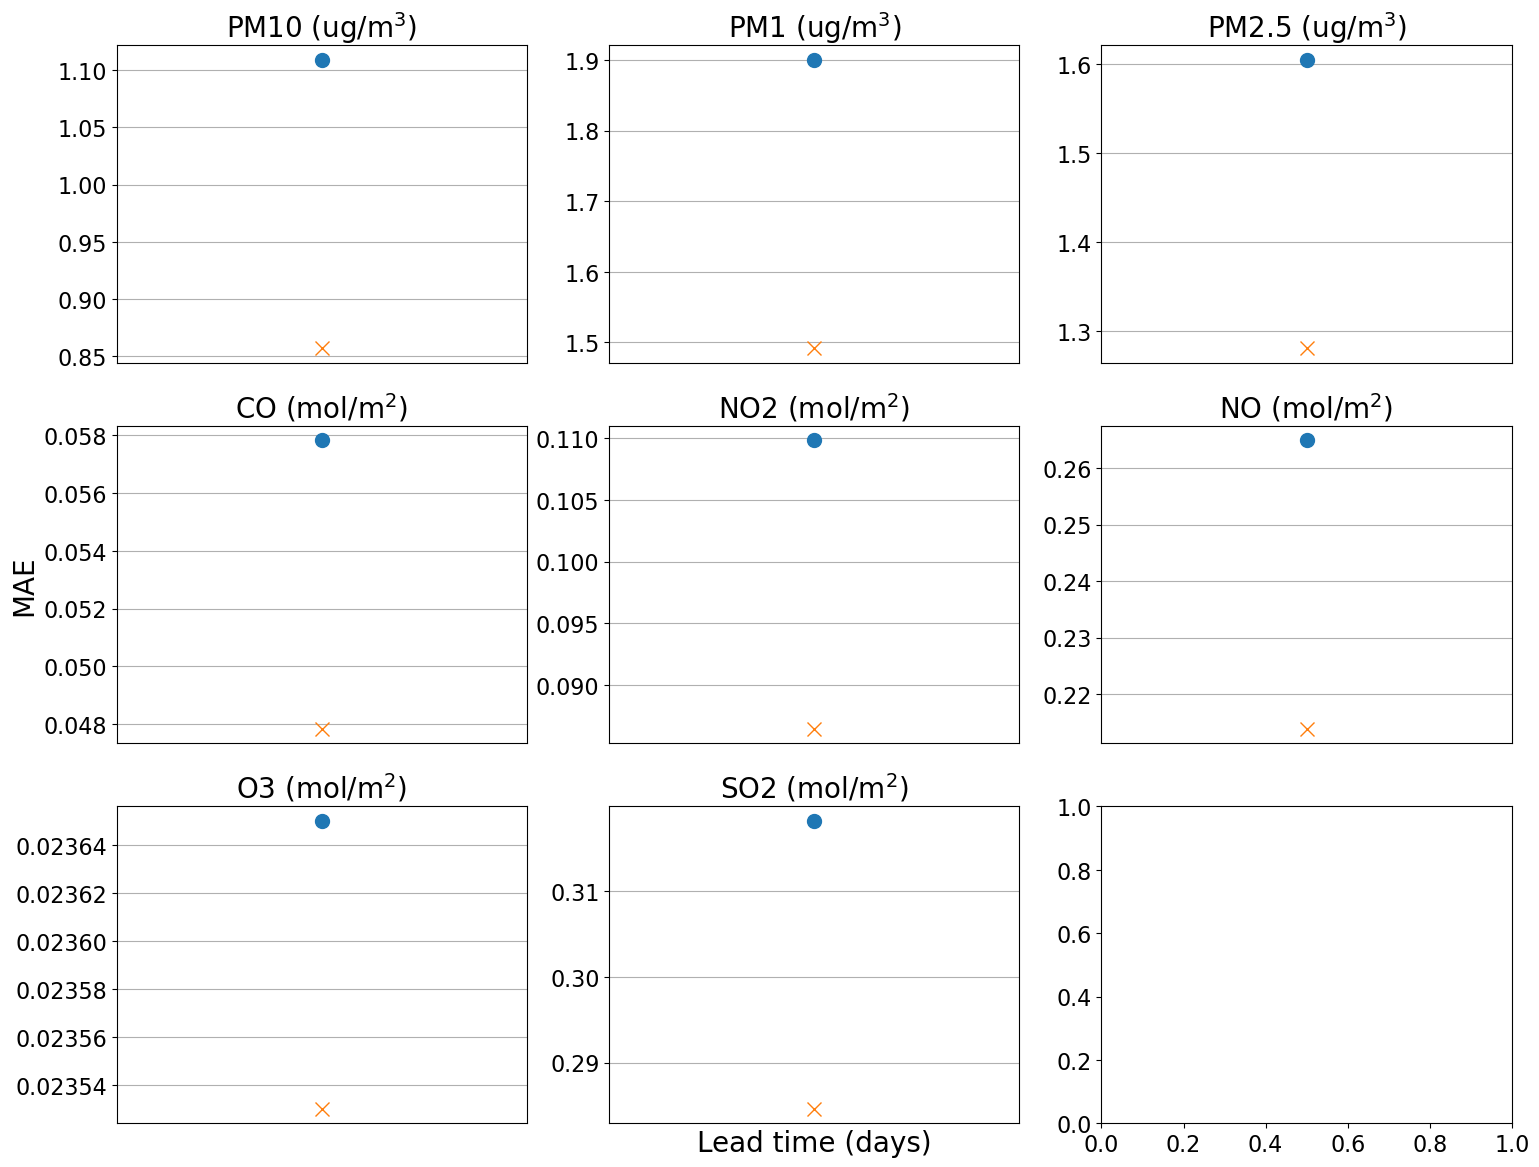

In [13]:
plot(
    [
        "particulate_matter_10um",
        "particulate_matter_1um",
        "particulate_matter_2.5um",
        "total_column_carbon_monoxide",
        "total_column_nitrogen_dioxide",
        "total_column_nitrogen_monoxide",
        "total_column_ozone",
        "total_column_sulphur_dioxide",
    ],
    'lat_rmse',
    baseline_results=baseline_results,
    baselines=[
        # 'Climatology', 
        'ClimaX',
        'Unet',
        # 'Persistence', 
        # 'Pangu-Weather', 
        # 'GraphCast', 
        # 'Stormer',
        # 'Stormer-HR', 
        # 'IFS HRES',
        # 'IFS ENS (mean)'
    ],
    lead_time_list=[24, 72, 120],
    n_cols=3,
    figsize=(18,14),
    filename='chem_forecasting.pdf',
)

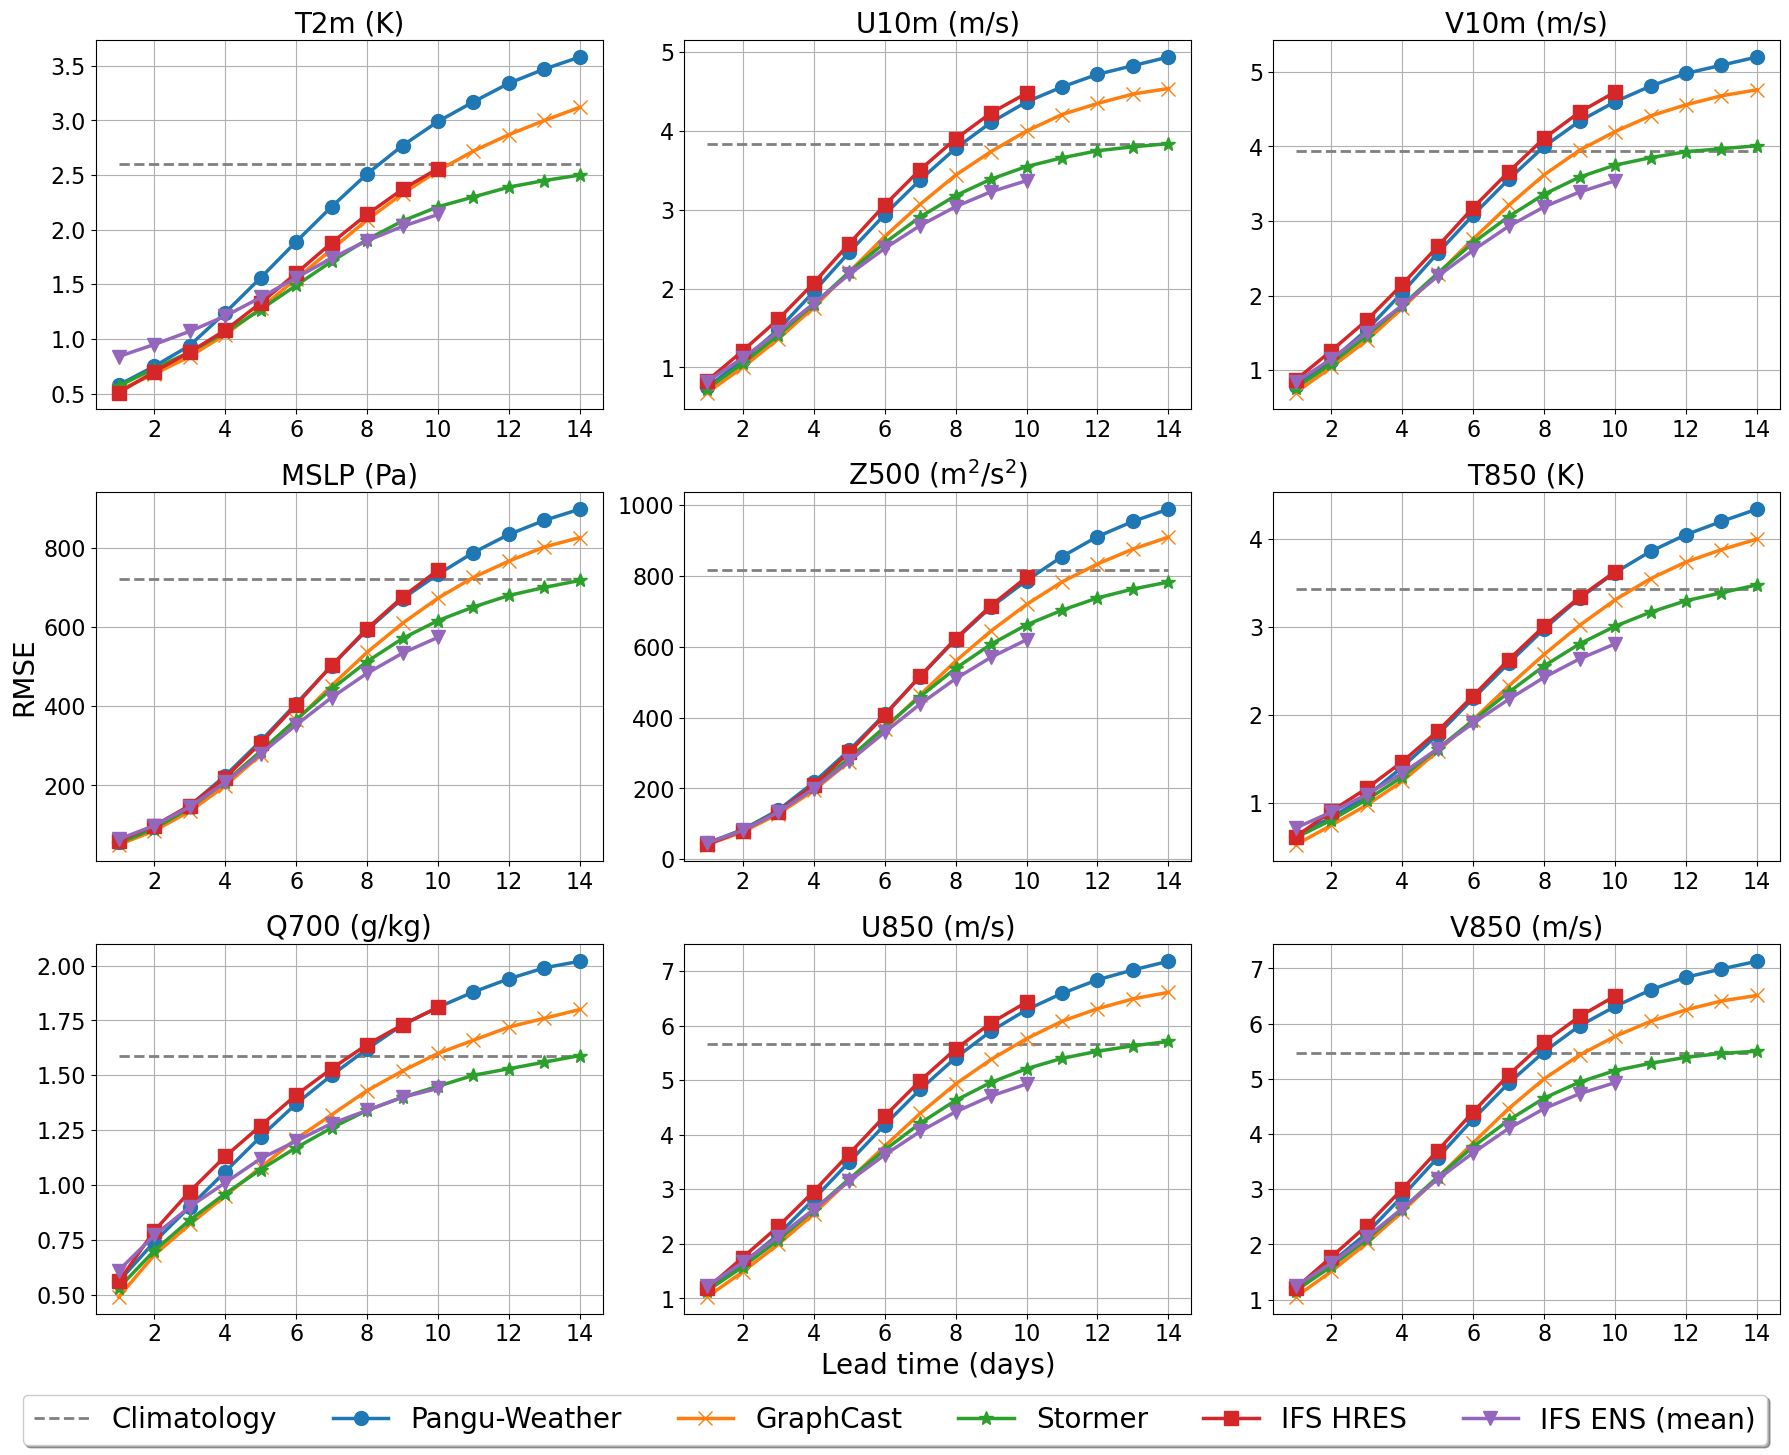

In [8]:
plot(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_rmse',
    baseline_results=baseline_results,
    baselines=[
        'Climatology', 
        # 'Persistence', 
        'Pangu-Weather', 
        'GraphCast', 
        'Stormer',
        # 'Stormer-HR', 
        'IFS HRES',
        'IFS ENS (mean)'
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='full_rmse.pdf',
)

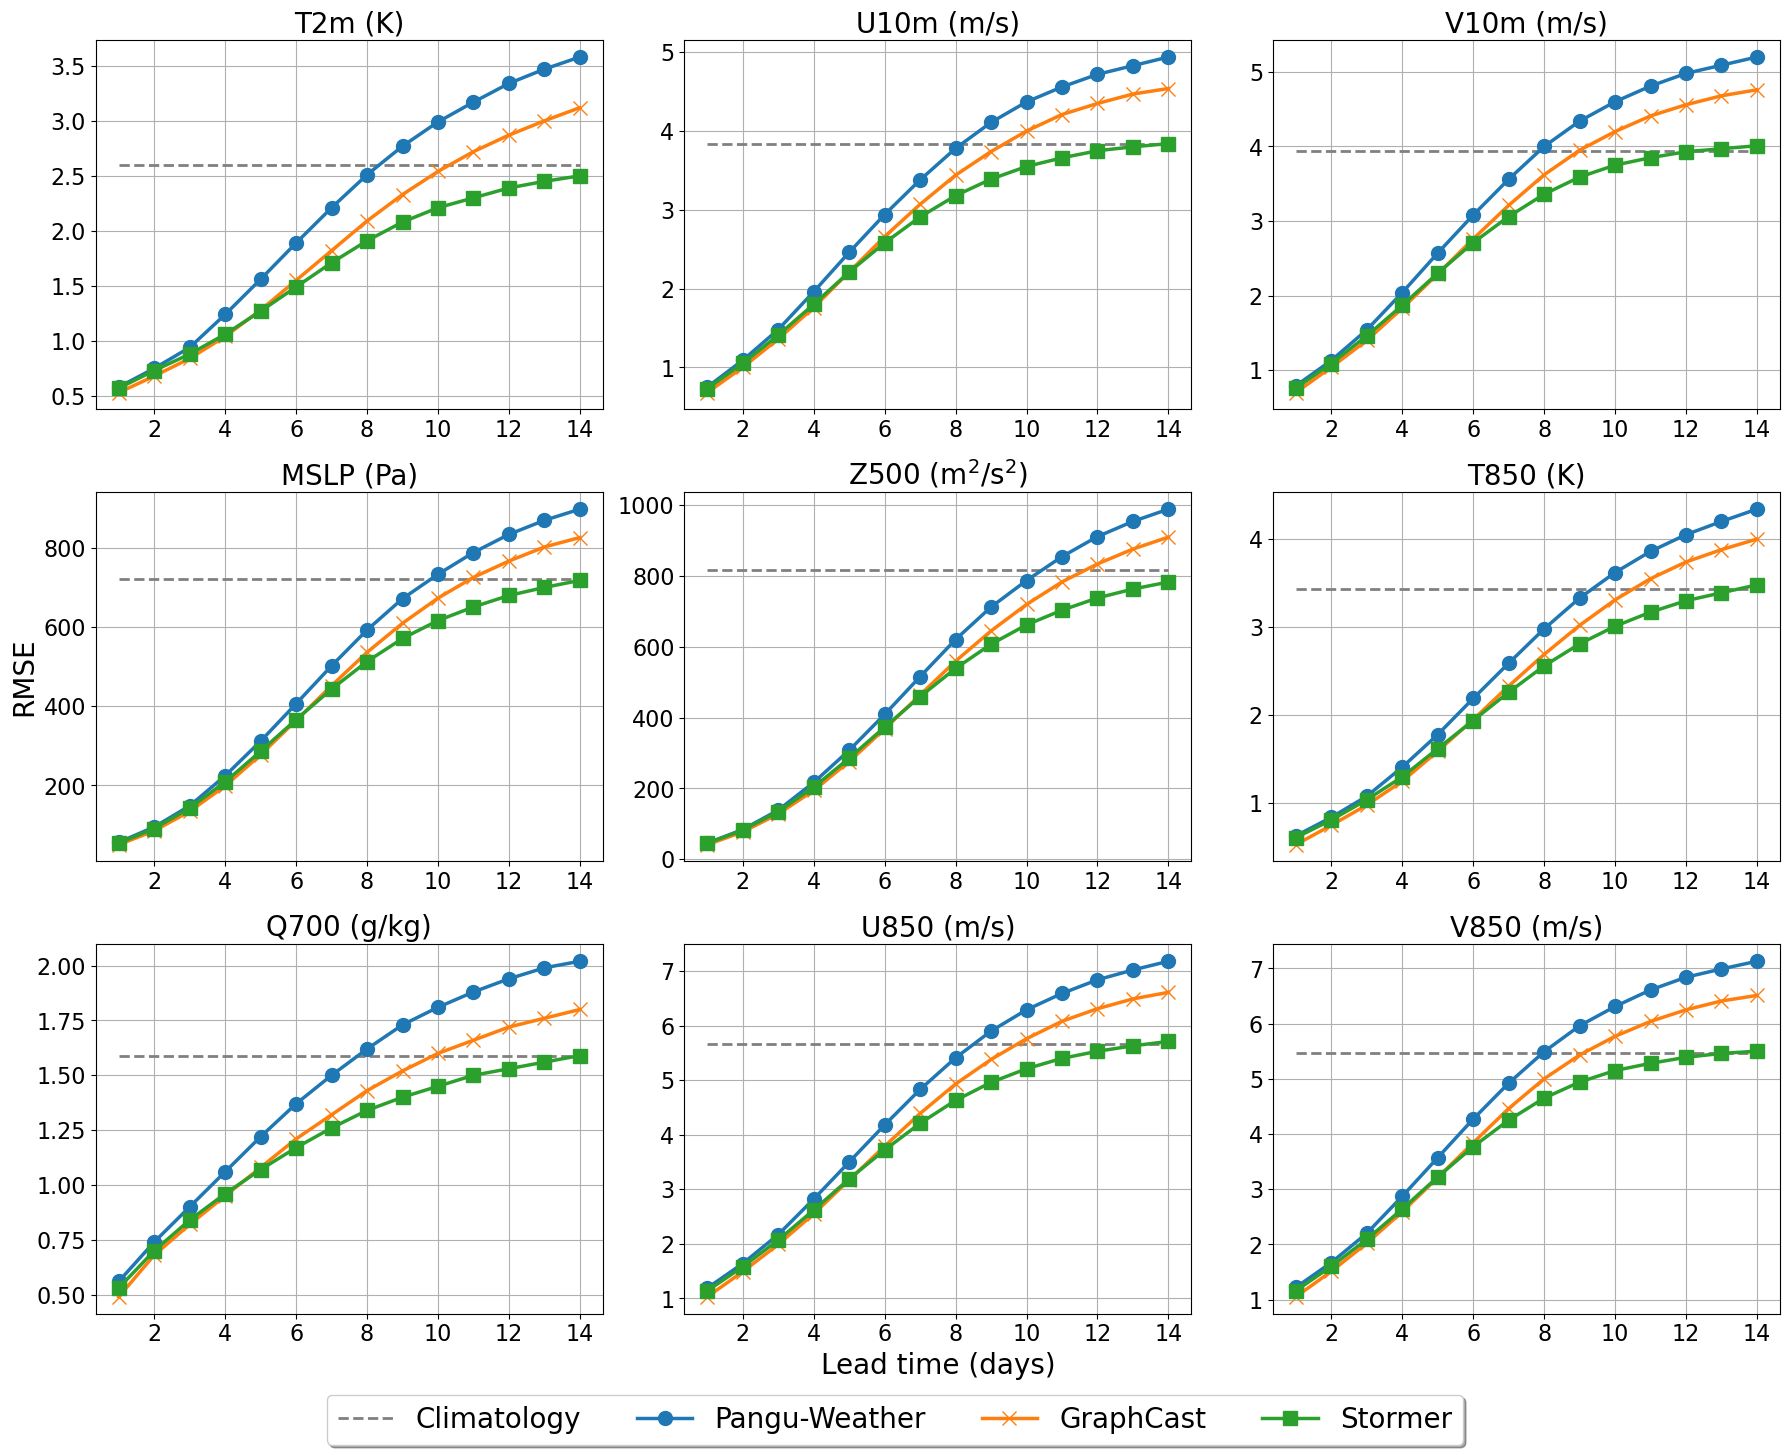

In [36]:
plot(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_rmse',
    baseline_results=baseline_results,
    baselines=['Climatology', 'Pangu-Weather', 'GraphCast', 'Stormer'],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='main_rmse.pdf',
)

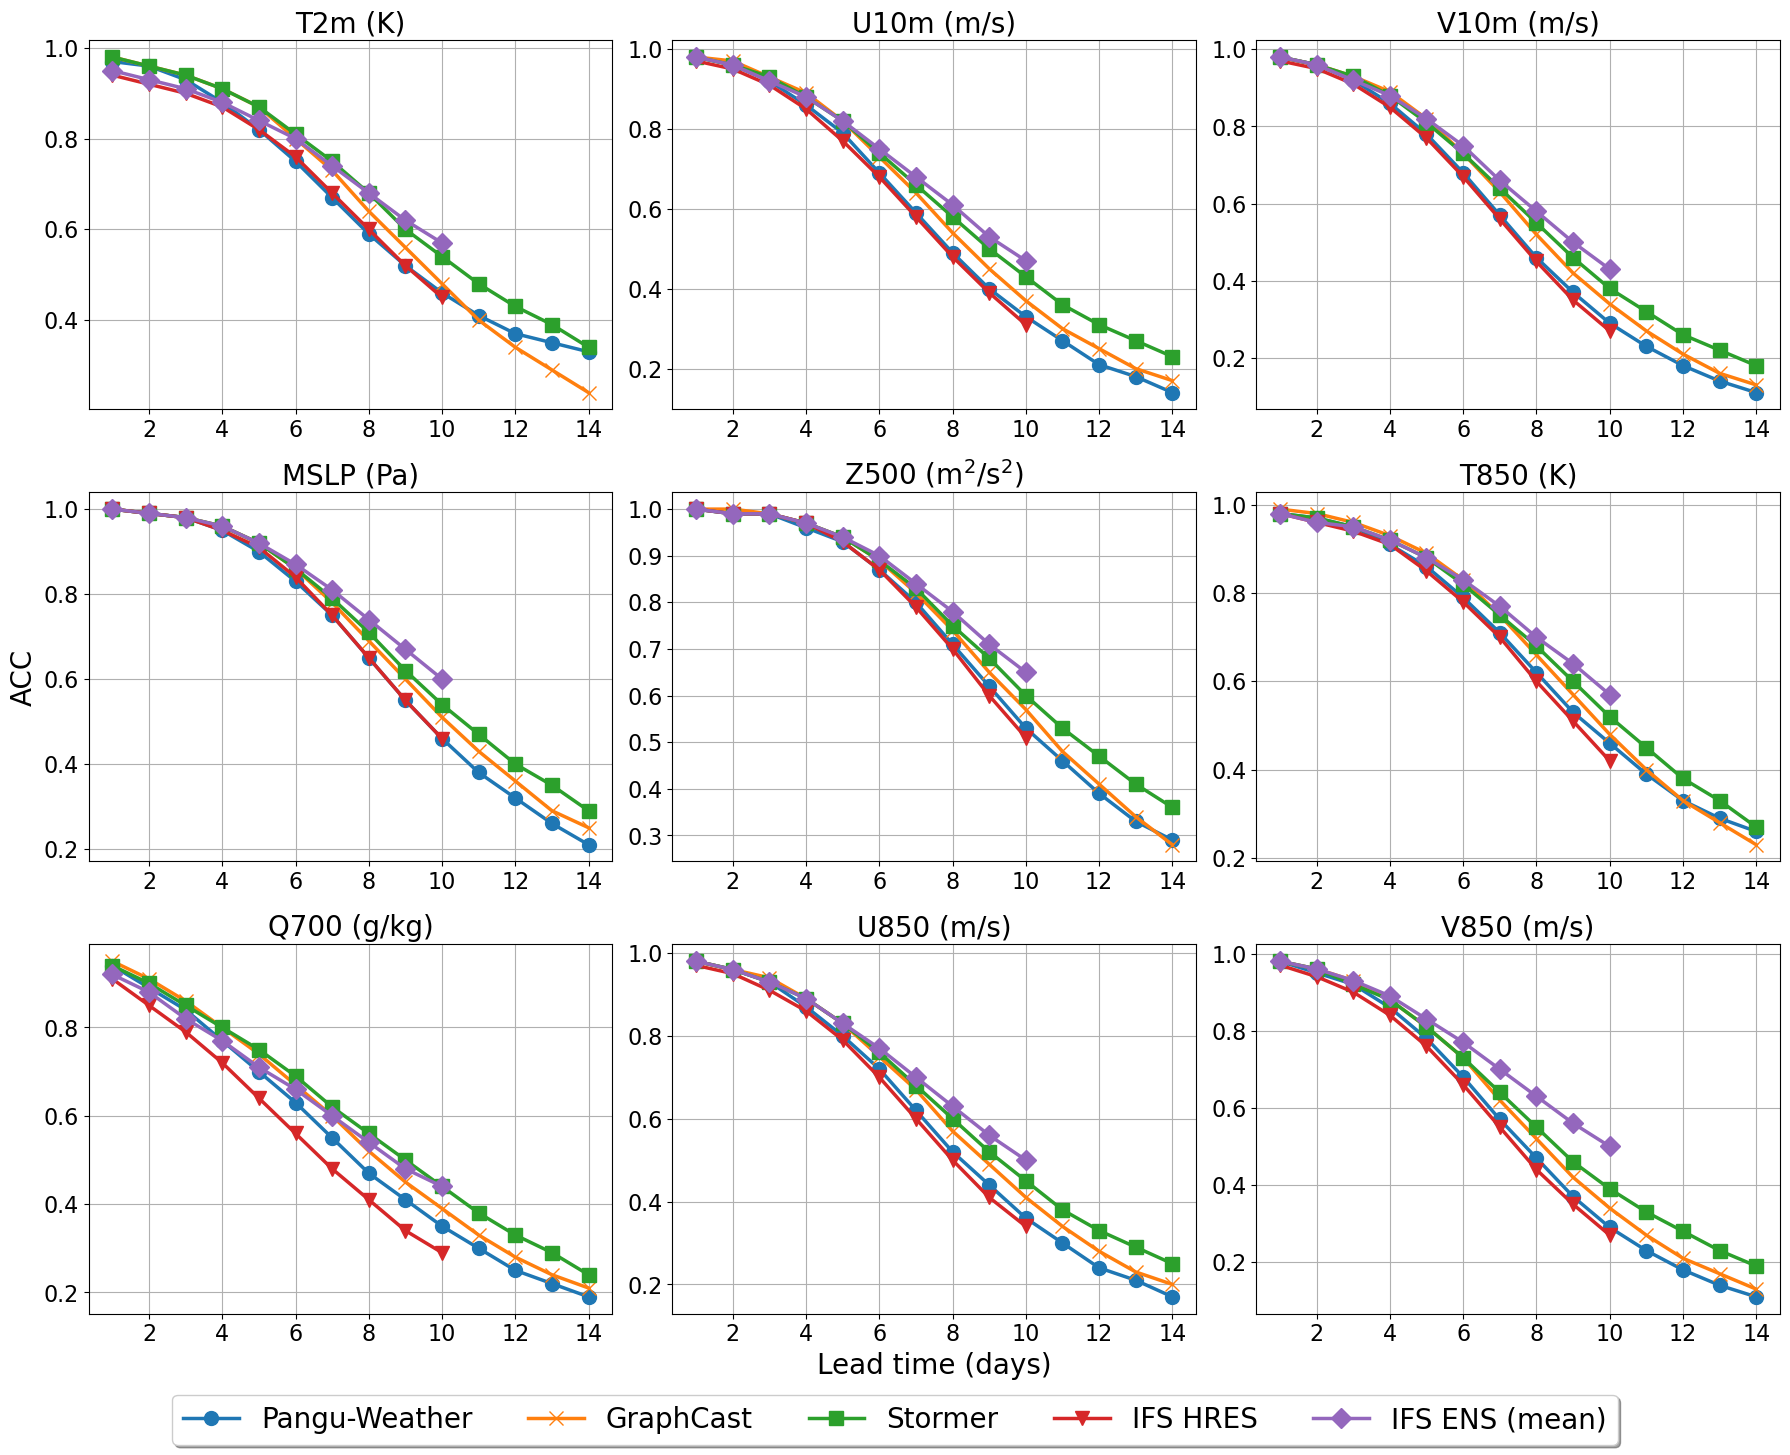

In [37]:
plot(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_acc',
    baseline_results=baseline_acc_results,
    baselines=['Pangu-Weather', 'GraphCast', 'Stormer', 'IFS HRES', 'IFS ENS (mean)'],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='full_acc.pdf',
)

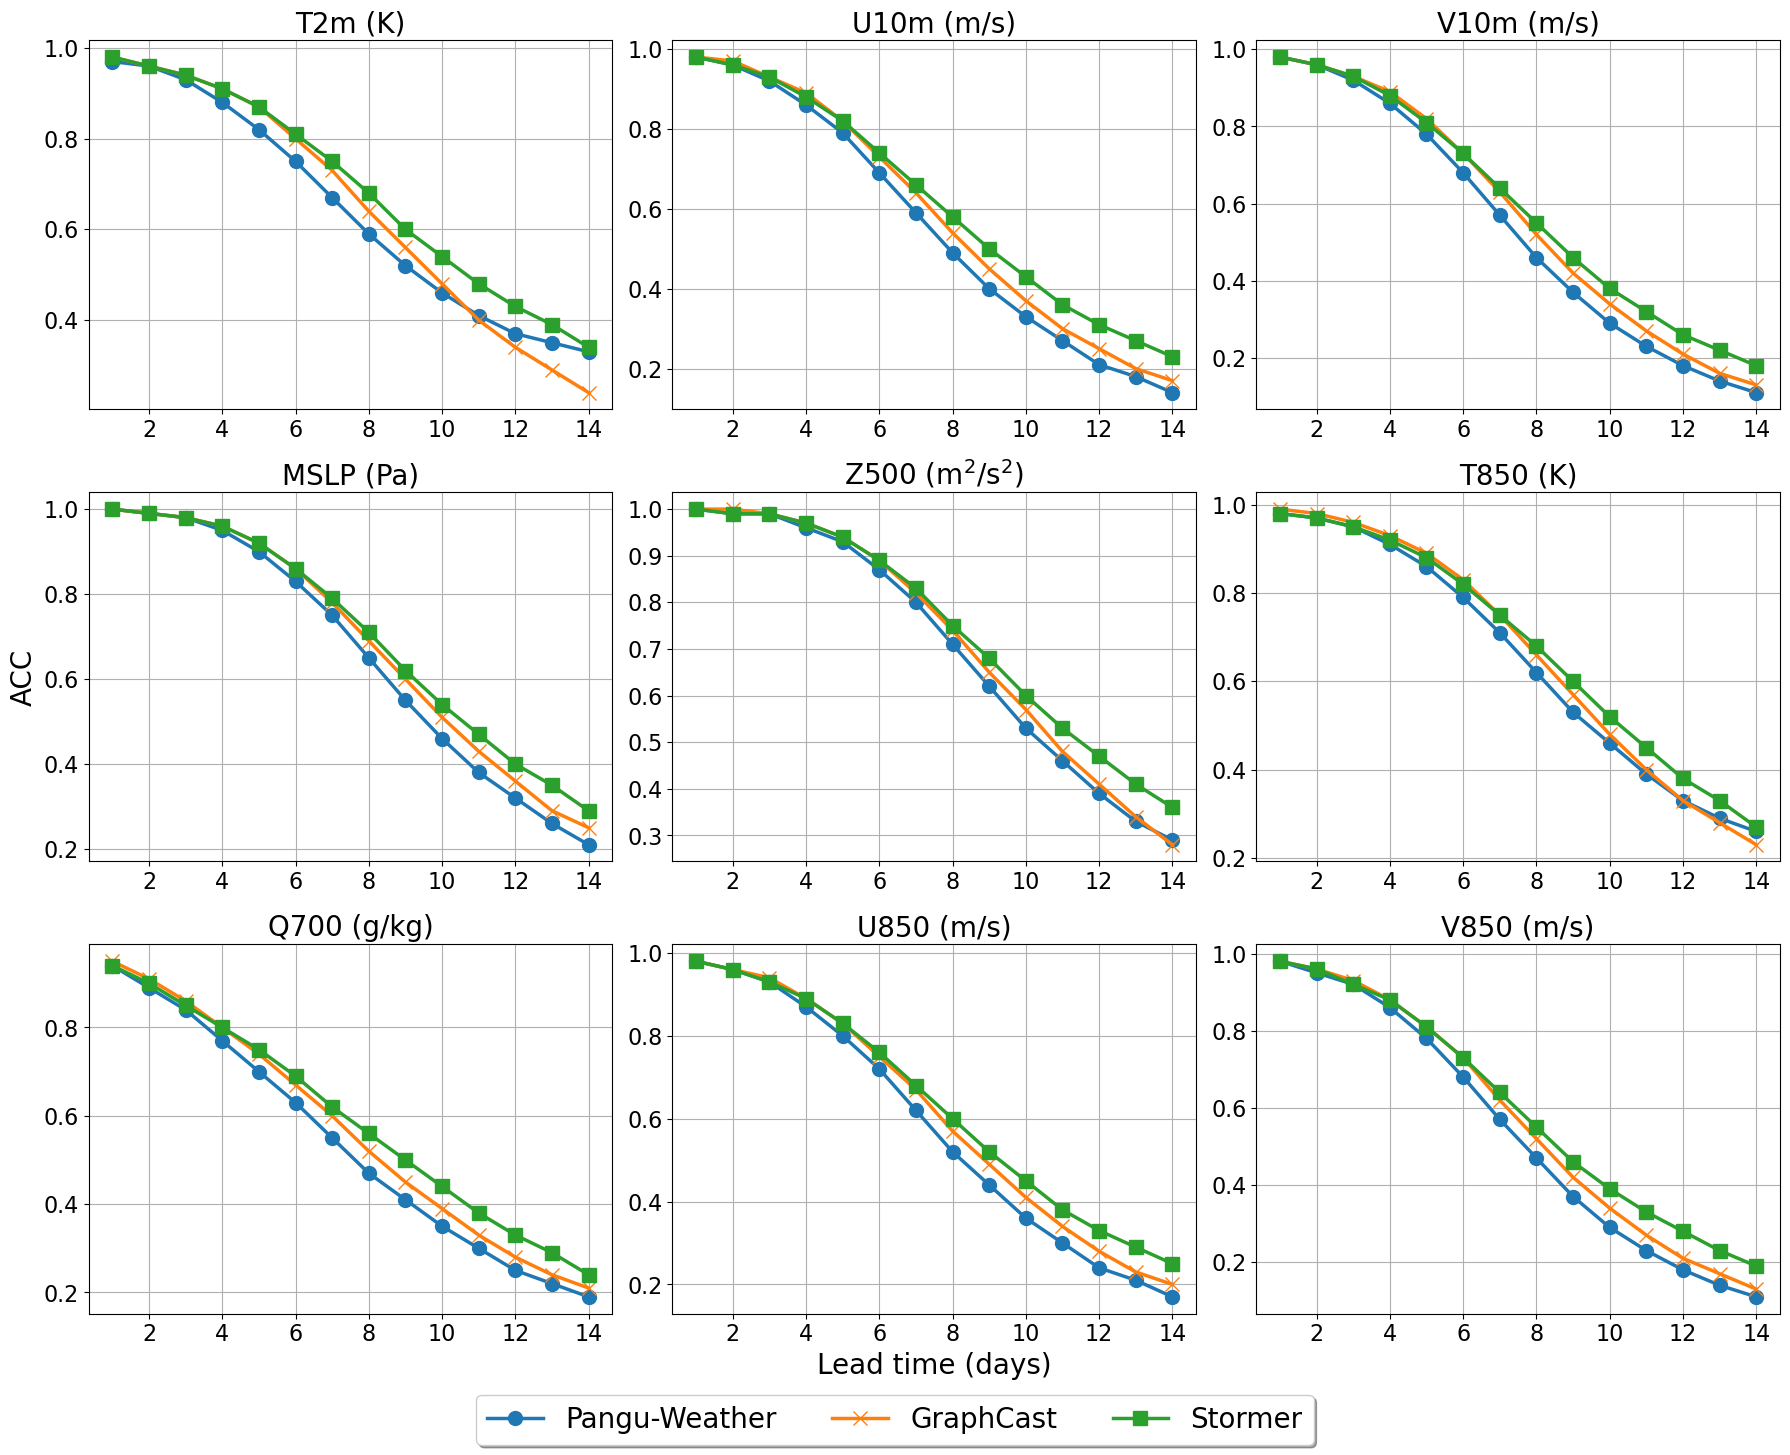

In [38]:
plot(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_acc',
    baseline_results=baseline_acc_results,
    baselines=['Pangu-Weather', 'GraphCast', 'Stormer'],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='main_acc.pdf',
)

In [14]:
def plot_csv(
    var_list,
    metric,
    path_list,
    metric_postfix_list,
    label_list,
    lead_time_list=[6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=3,
    figsize=(22,15),
    filename=None,
    baseline_results=None,
    baselines=None,
):
    assert len(path_list) == len(label_list)
    
    markers = ['o', 'x', 's', 'v', 'D']
    
    n_rows = len(var_list) // n_cols if len(var_list) % n_cols == 0 else len(var_list) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()

    for i, var in enumerate(var_list):
        if n_rows > 1 or n_cols > 1:
            ax = axes[i]
        else:
            ax = axes
        title = var_map[var]
        ax.set_title(title)
        ax.tick_params(axis='both', which='both')

        if metric == 'lat_rmse':
            y_label = 'RMSE'
        elif metric == 'lat_acc':
            y_label = 'ACC'

        if i == (n_rows // 2) * n_cols:
            ax.set_ylabel(y_label)
        if i == (n_rows - 1)*n_cols + n_cols // 2:
            ax.set_xlabel("Lead time (days)")
        
        ax.set_xticks([l//24 for l in lead_time_list][1::2])
        
        marker_id = -1
        if baseline_results is not None:
            for marker_id, model in enumerate(baselines):
                lead_time_list_baseline = baseline_results[model][var]['lead_times']
                lead_time_list_baseline = [l for l in lead_time_list_baseline if l in lead_time_list]
                metric_list = baseline_results[model][var][metric][:len(lead_time_list_baseline)]
                if len(metric_list) > 0:
                    if model != 'Climatology':
                        ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, marker=markers[marker_id])
                    else:
                        ax.plot([l // 24 for l in lead_time_list_baseline], metric_list, label=model, linewidth=2, color='gray', linestyle='--')
                else:
                    ax.plot([], [], label=model, marker='o')

        # for each model
        for j in range(len(path_list)):
            path = path_list[j]
            df_result = read_wandb_log(path, version=0)
            ys = []
            for lead_time in lead_time_list:
                key = f'test/{metric}_{lead_time}_hrs:{var}_{metric_postfix_list[j]}'
                ys.append(df_result[key])
                
            if 'specific_humidity' in var:
                ys = [y * 1000 for y in ys]
            
            if label_list[j] == 'Stormer':
                ax.plot([l // 24 for l in lead_time_list], ys, label=label_list[j], marker='*')
            else:
                ax.plot([l // 24 for l in lead_time_list], ys, label=label_list[j], marker=markers[marker_id + j + 1])
        
        ax.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    fig.legend(
        by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True, ncol=len(labels)
    )
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

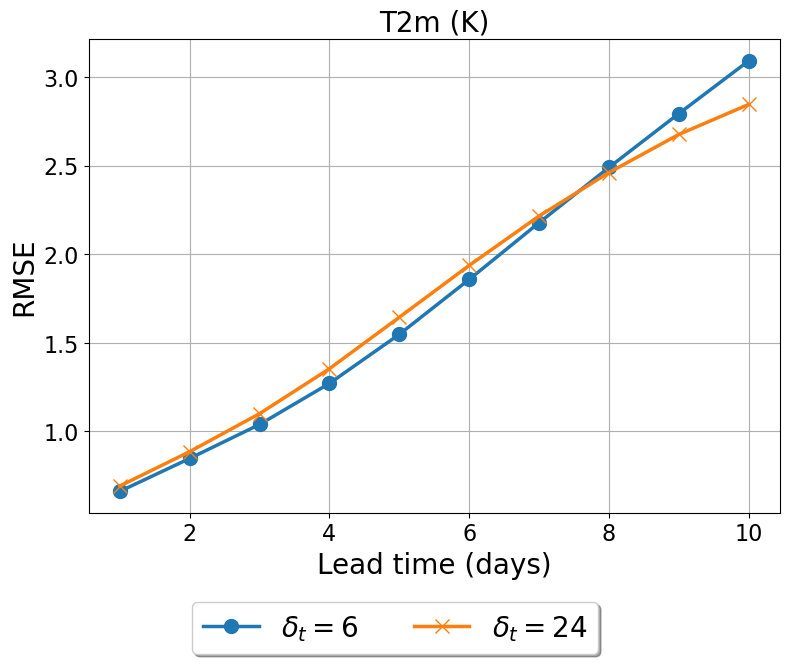

In [9]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_climax_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/24_climax_large_4_True_delta_1_homo',
    ],
    [
        "base_6",
        # "base_12",
        "base_24",
    ],
    [
        '$\delta_t = 6$',
        # '$\delta_t = 12$',
        '$\delta_t = 24$',
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='compare_lead_time.pdf',
    baseline_results=None,
    baselines=None,
)

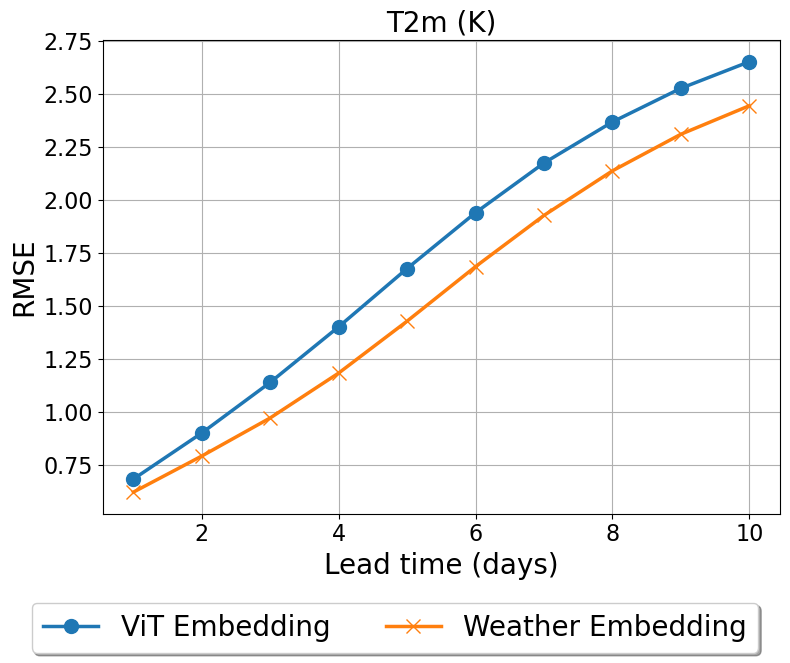

In [10]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_conv_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        'ViT Embedding',
        'Weather Embedding',
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='compare_embedding.pdf',
    baseline_results=None,
    baselines=None,
)

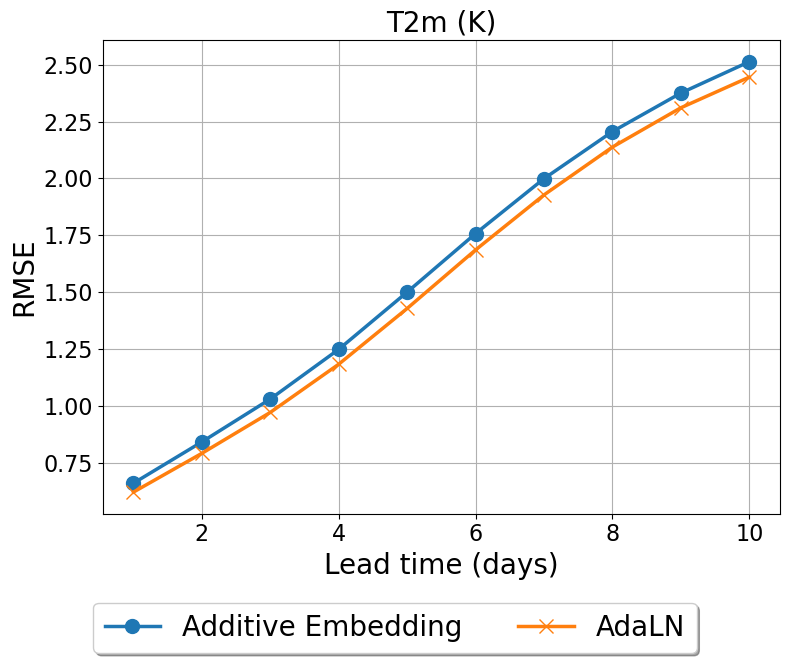

In [12]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_addition_lead_time_emb_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        'Additive Embedding',
        'AdaLN',
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='compare_adaln.pdf',
    baseline_results=None,
    baselines=None,
)

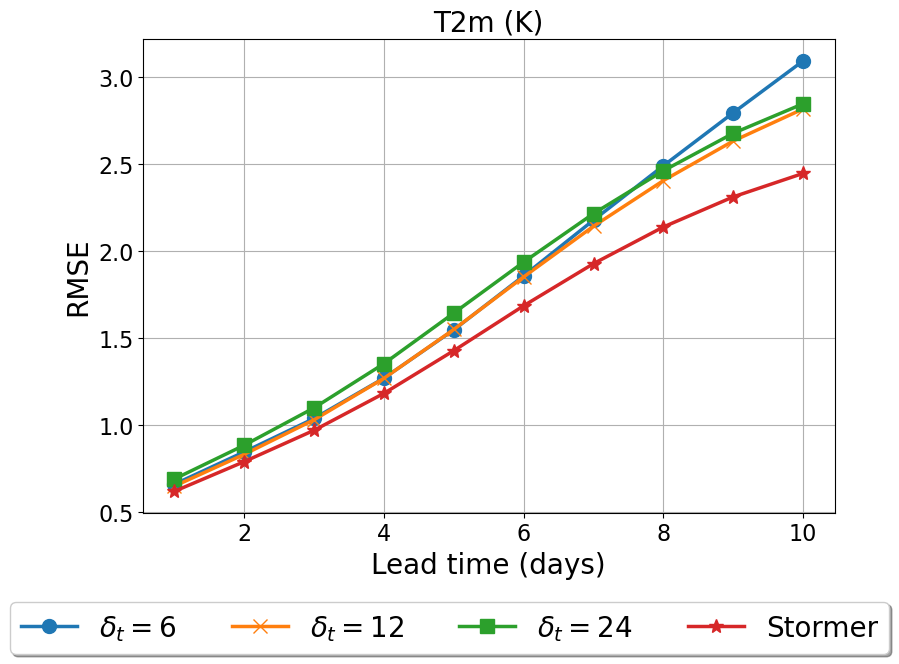

In [15]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_climax_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/12_climax_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/24_climax_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "base_6",
        "base_12",
        "base_24",
        "ensemble_mean",
    ],
    [
        "$\delta_t = 6$",
        "$\delta_t = 12$",
        "$\delta_t = 24$",
        "Stormer",
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='randomized_effect.pdf',
    baseline_results=None,
    baselines=None,
)

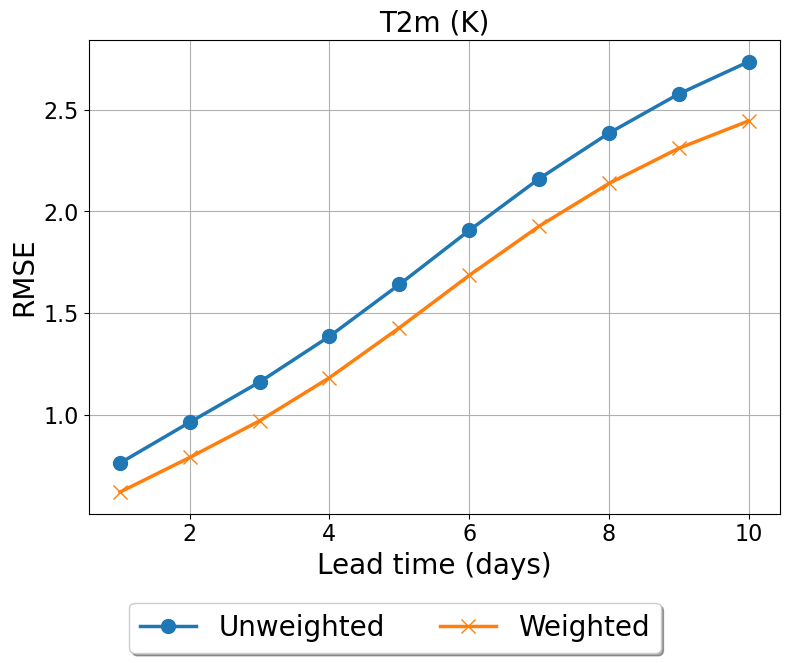

In [16]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_False_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "Unweighted",
        "Weighted"
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='weighting_effect.pdf',
    baseline_results=None,
    baselines=None,
)

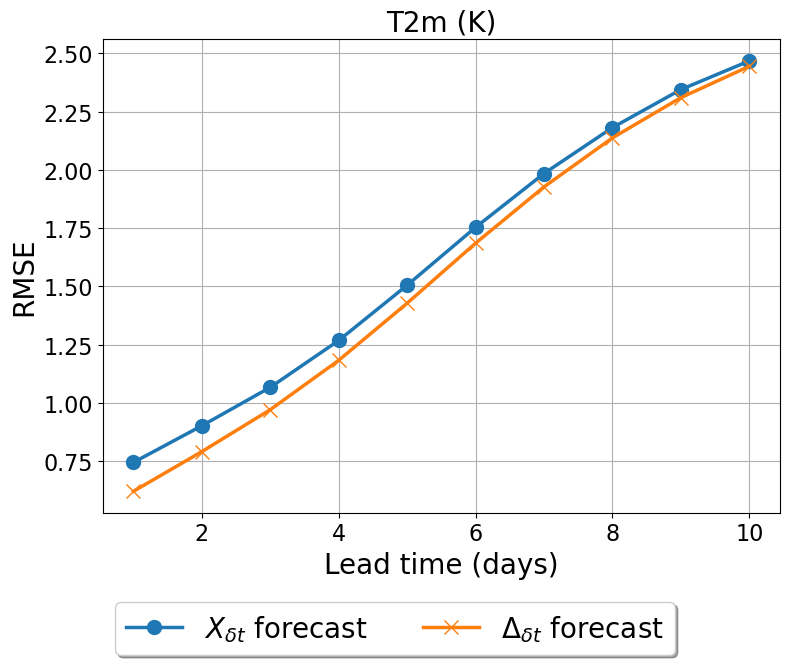

In [17]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_abs_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "$X_{\delta t}$ forecast",
        "$\Delta_{\delta t}$ forecast"
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='delta_vs_abs.pdf',
    baseline_results=None,
    baselines=None,
)

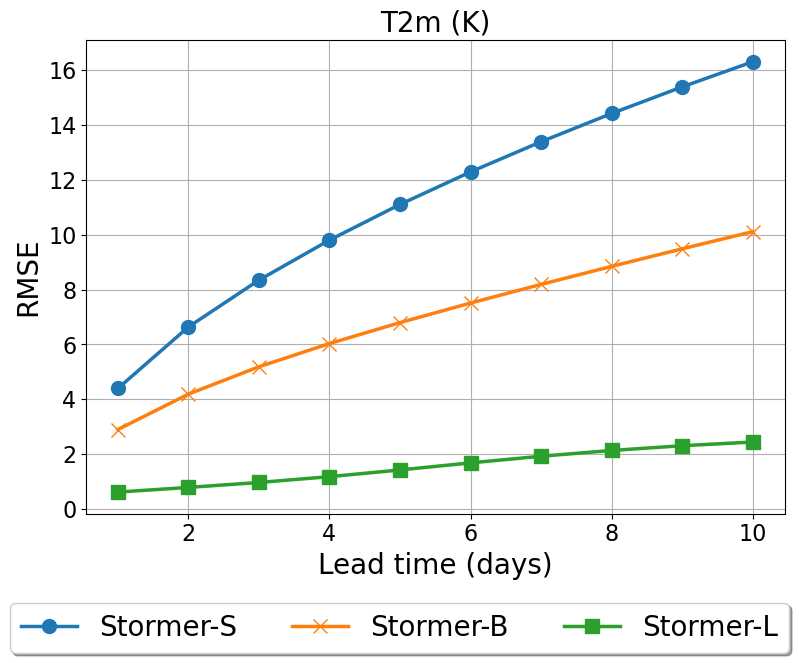

In [19]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_small_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_base_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "Stormer-S",
        "Stormer-B",
        "Stormer-L",
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='scaling_model.pdf',
    baseline_results=None,
    baselines=None,
)

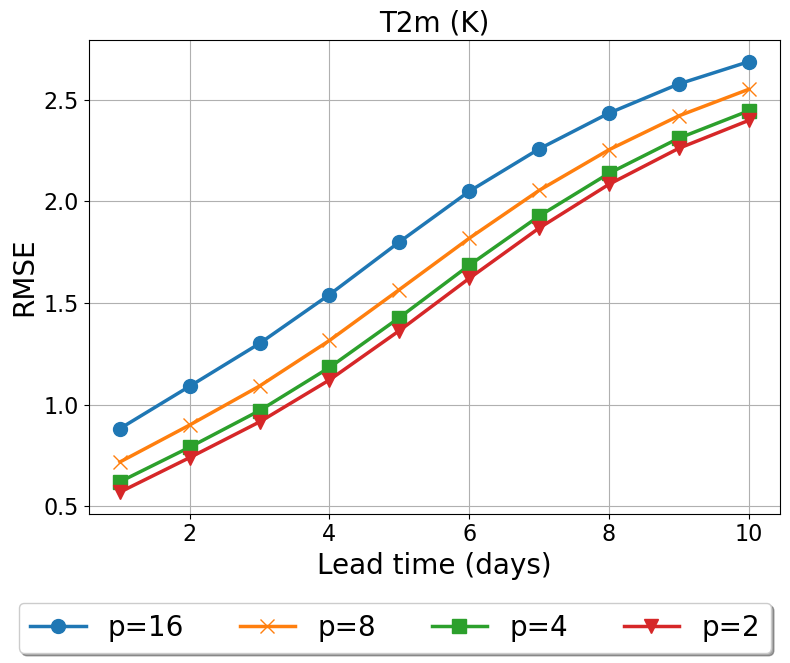

In [22]:
plot_csv(
    [
        '2m_temperature',
        # '10m_u_component_of_wind',
        # '10m_v_component_of_wind',
        # 'geopotential_500',
        # 'temperature_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_16_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_8_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_4_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_2_True_delta_1_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "p=16",
        "p=8",
        "p=4",
        "p=2",
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=1,
    figsize=(8,6),
    filename='scaling_tokens.pdf',
    baseline_results=None,
    baselines=None,
)

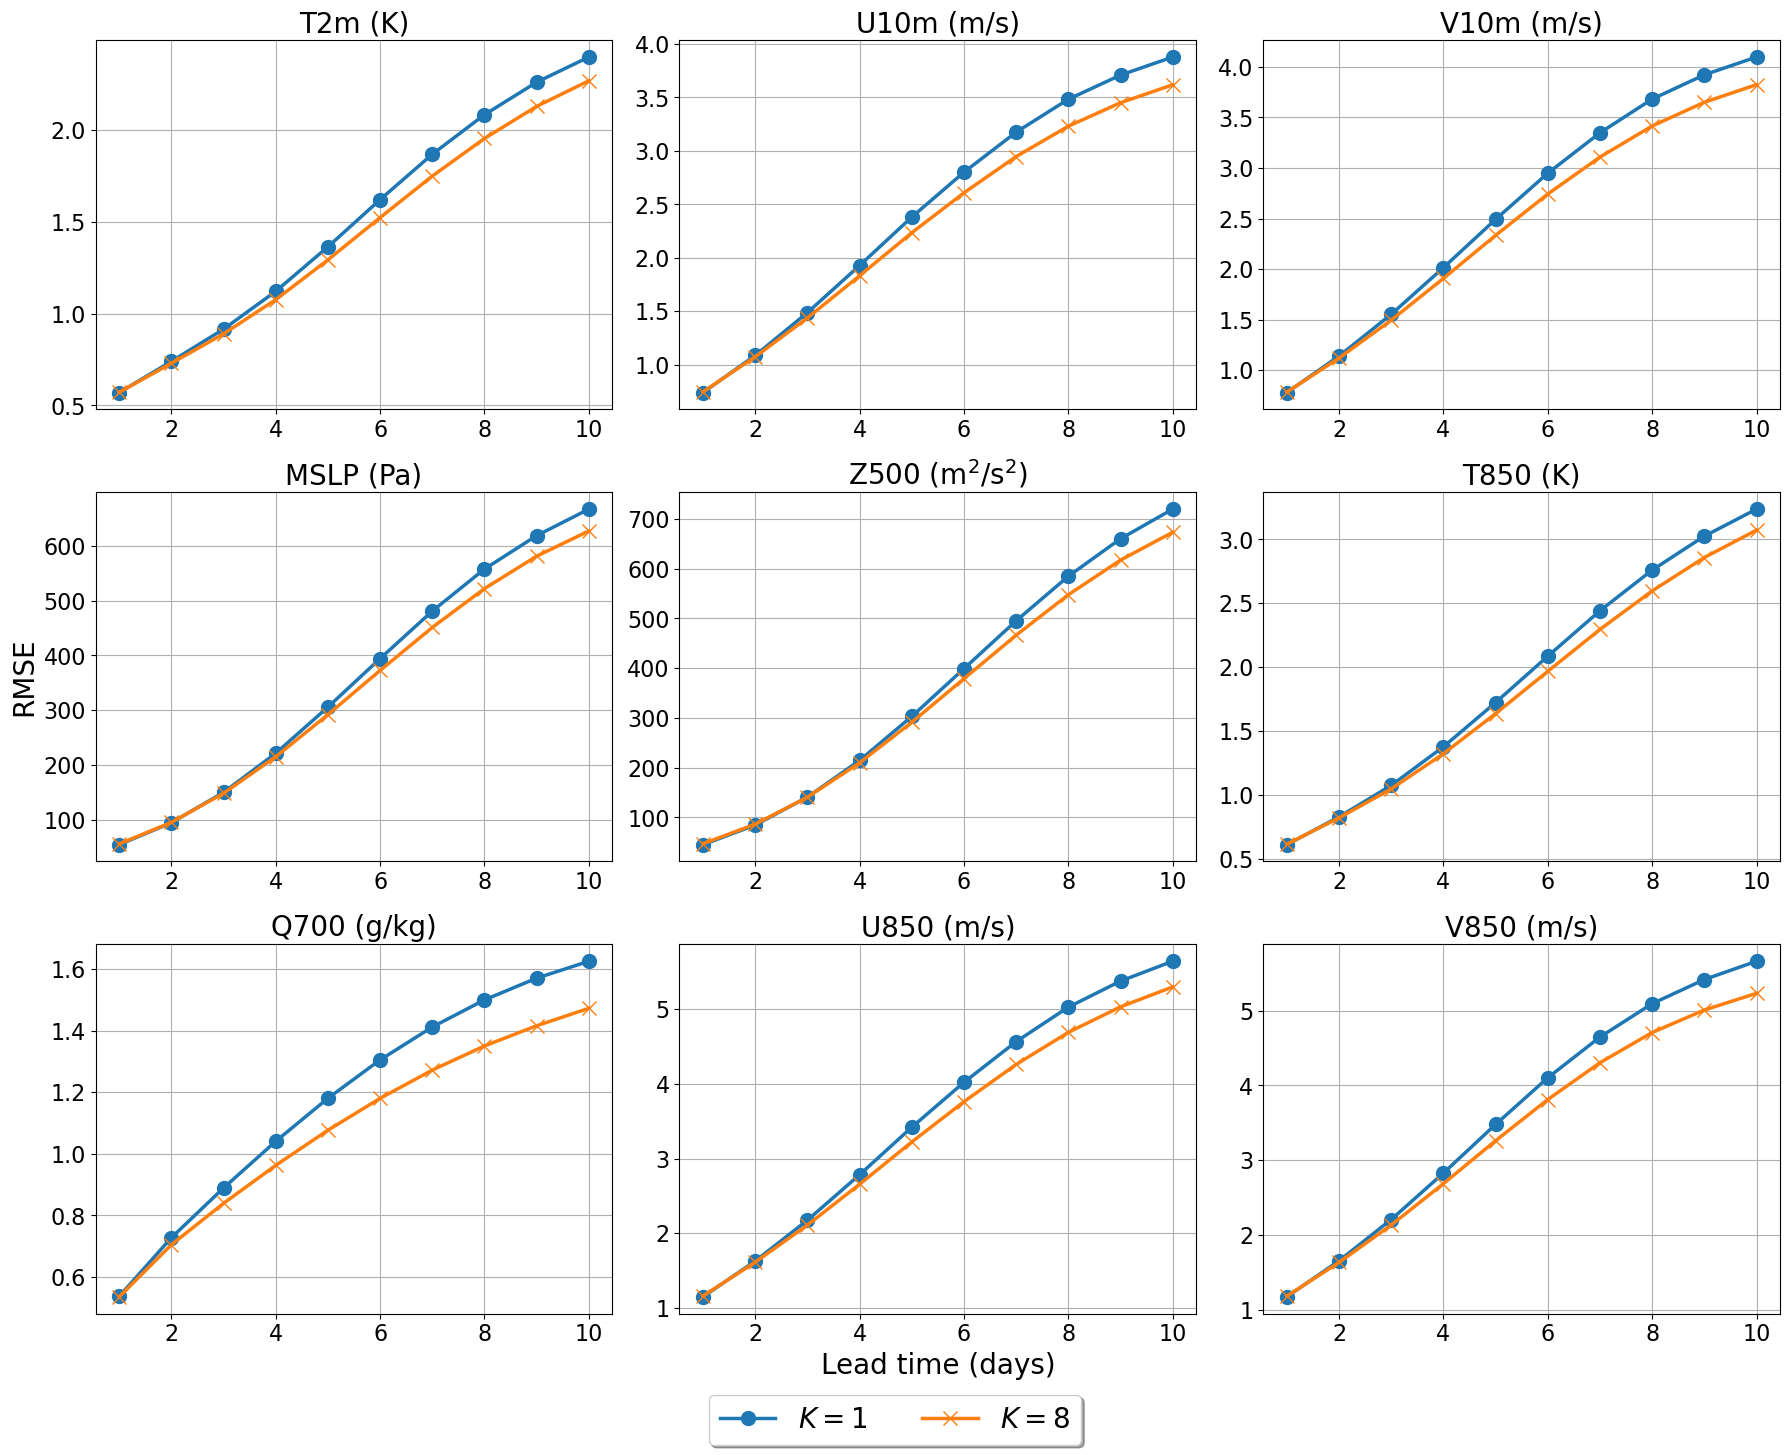

In [23]:
plot_csv(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_2_True_delta_1_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_2_True_delta_8_homo',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "$K=1$",
        "$K=8$",
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=3,
    figsize=(18,14),
    filename='multi_step_finetune.pdf',
    baseline_results=None,
    baselines=None,
)

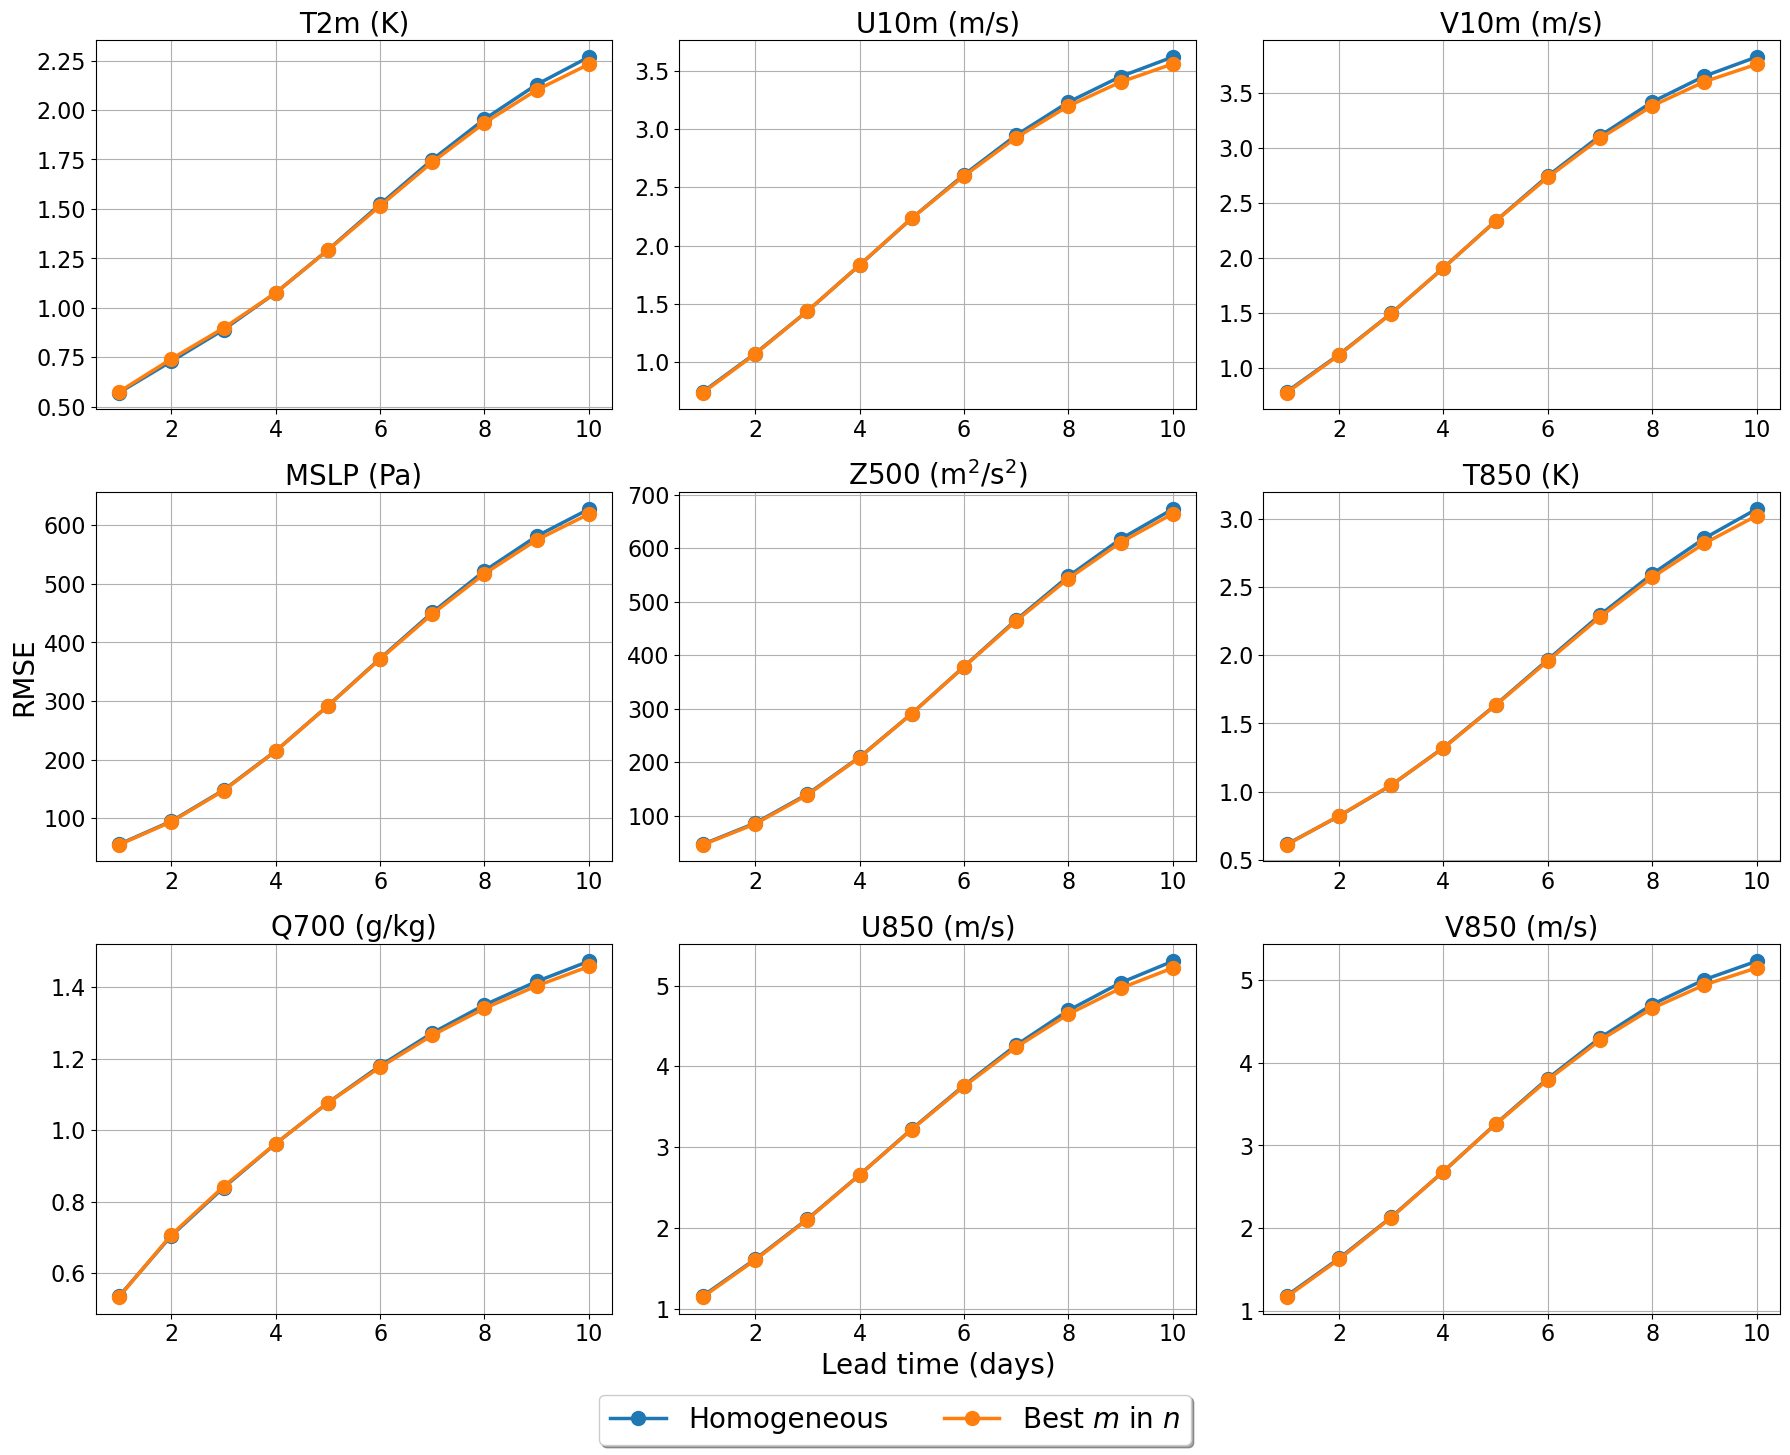

In [32]:
plot(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_rmse',
    [
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_2_True_delta_8_homo',
        '/eagle/MDClimSim/tungnd/wet/results/6_12_24_climax_large_2_True_delta_8_best_32_in_128',
    ],
    [
        "ensemble_mean",
        "ensemble_mean",
    ],
    [
        "Homogeneous",
        "Best $m$ in $n$",
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=3,
    figsize=(18,14),
    filename='inference_compare.pdf',
    baseline_results=None,
    baselines=None,
)

In [7]:
# def print_results(root_dir, var_list, post_fix, metric, metric_postfix, arc, model, pretrained, lead_time_list):
#     for variable in var_list:
#         json_result = read_wandb_log(
#             root_dir=root_dir,
#             arc=arc,
#             model=model,
#             pretrained=pretrained,
#             post_fix=post_fix
#         )
#         ys = []
#         for lead_time in lead_time_list:
#             if metric_postfix is None:
#                 key = f'test/{metric}_{lead_time}_hrs:{variable}'
#             else:
#                 key = f'test/{metric}_{lead_time}_hrs:{variable}_{metric_postfix}'
#             if 'specific_humidity' in variable:
#                 ys.append(round(json_result[key] * 1000, 2))
#             else:
#                 ys.append(round(json_result[key], 2))
#         print (variable, ys)

In [39]:
def plot_from_json(
    var_list,
    metric,
    json_paths,
    label_list,
    lead_time_list=[6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240],
    n_cols=3,
    figsize=(22,15),
    filename=None,
):
    assert len(json_paths) == len(label_list)
    
    markers = ['o', 'x', 'v', 's', 'D']
    
    json_results = []
    for path in json_paths:
        with open(path) as f:
            json_results.append(json.load(f))
    
    n_rows = len(var_list) // n_cols if len(var_list) % n_cols == 0 else len(var_list) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()

    for i, var in enumerate(var_list):
        if n_rows > 1 or n_cols > 1:
            ax = axes[i]
        else:
            ax = axes
        title = var_map[var]
        ax.set_title(title)
        ax.tick_params(axis='both', which='both')

        if metric == 'lat_rmse':
            y_label = 'RMSE'
        elif metric == 'lat_acc':
            y_label = 'ACC'

        if i == (n_rows // 2) * n_cols:
            ax.set_ylabel(y_label)
        if i == (n_rows - 1)*n_cols + n_cols // 2:
            ax.set_xlabel("Lead time (days)")
        
        ax.set_xticks([l//24 for l in lead_time_list][1::2])

        # for each model
        for j, result in enumerate(json_results):
            result_var = result[var]
            ys = list(result_var.values())
                
            if 'specific_humidity' in var and metric == 'lat_mse':
                ys = [y * 1000 for y in ys]
            
            if label_list[j] == 'Stormer':
                ax.plot([l // 24 for l in lead_time_list], ys, label=label_list[j], marker='*', color='red')
            else:
                ax.plot([l // 24 for l in lead_time_list], ys, label=label_list[j], marker=markers[j])
        
        ax.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    fig.legend(
        by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True, ncol=len(labels)
    )
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()

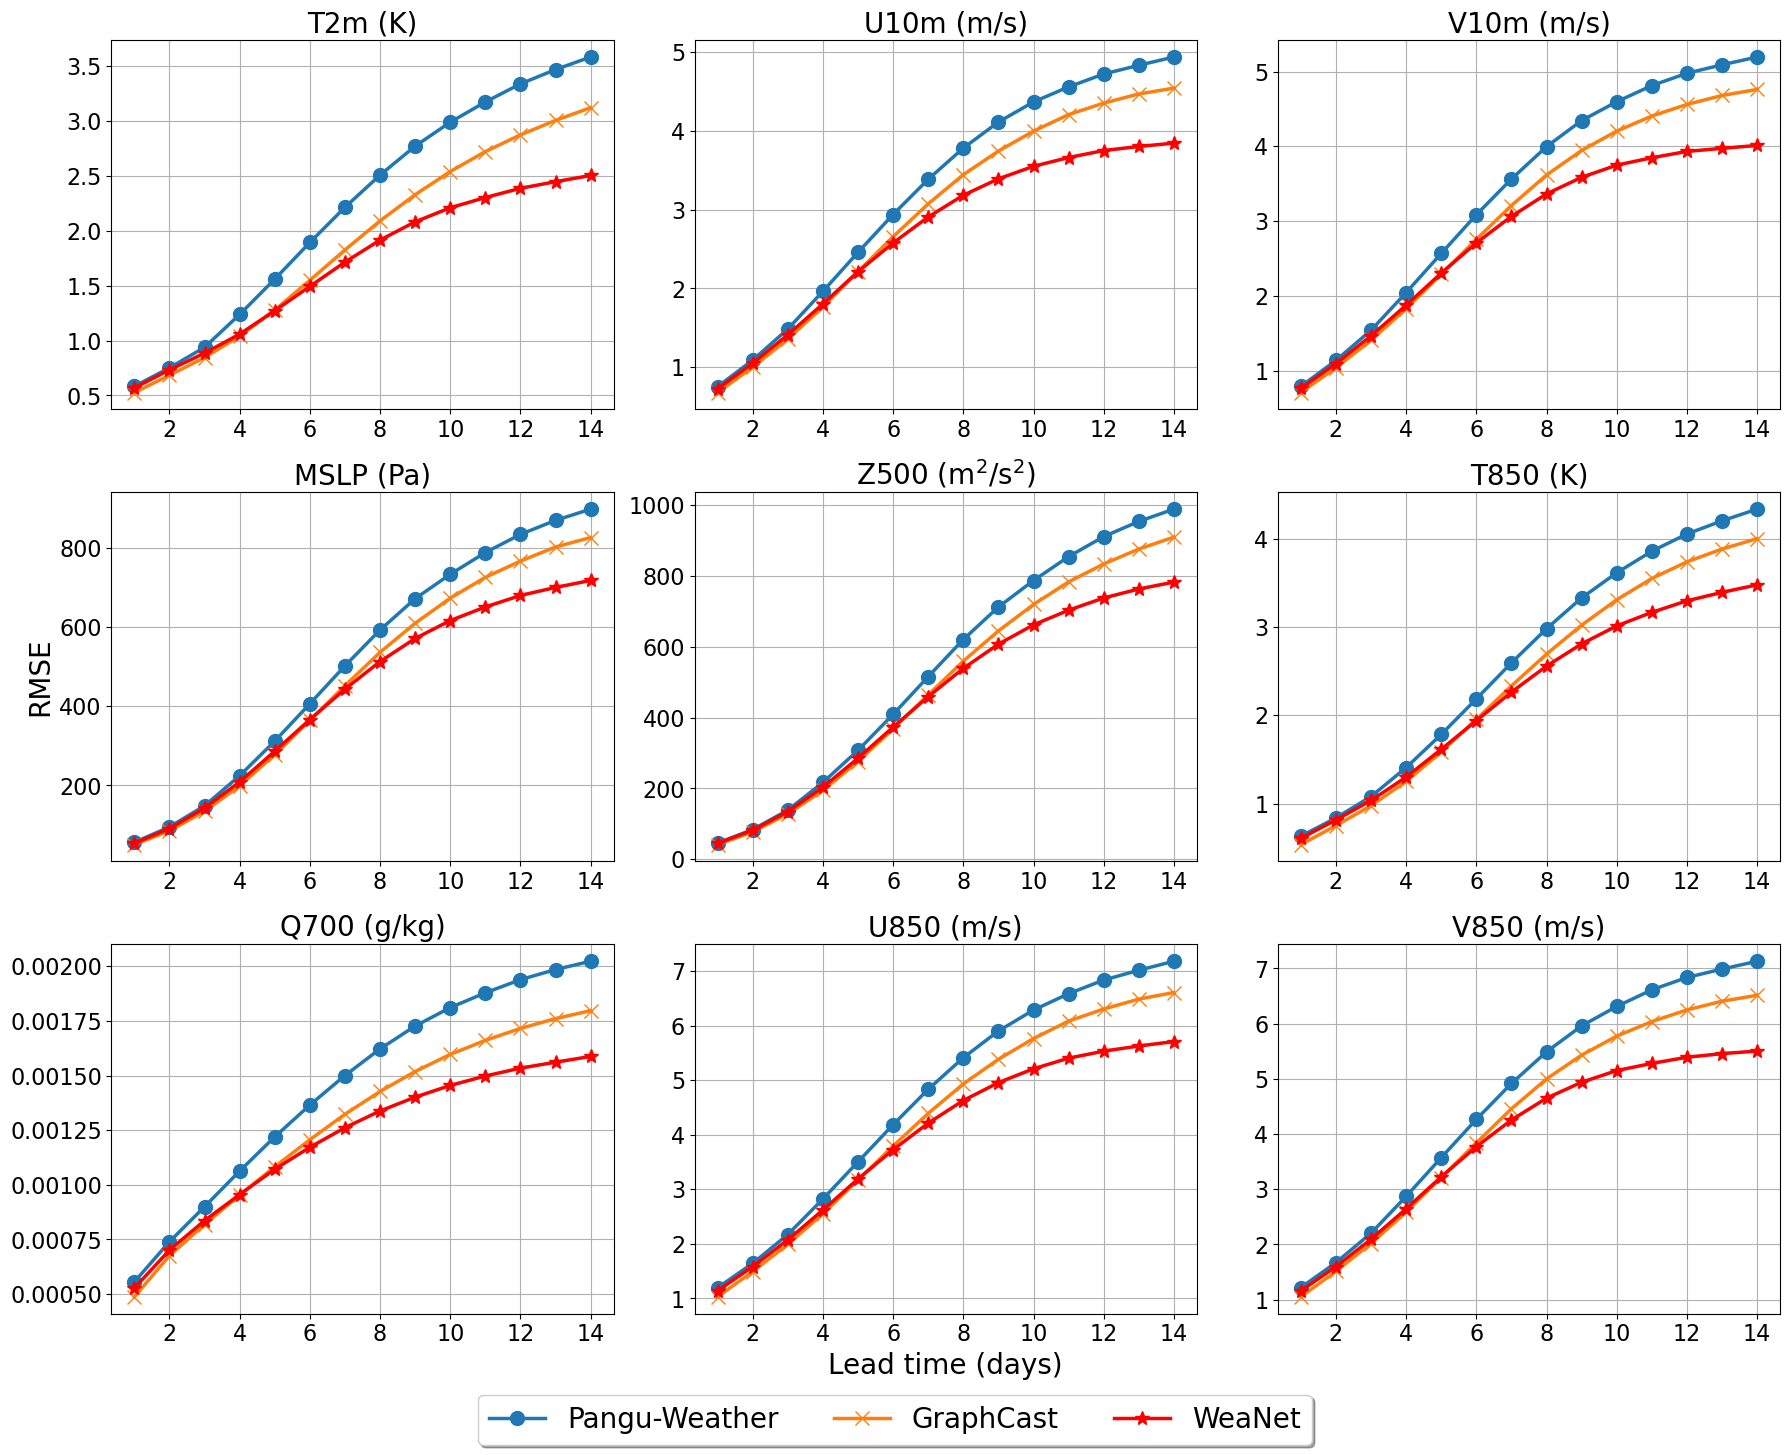

In [40]:
plot_from_json(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_rmse',
    [
        '../pangu_rmse.json',
        '../graphcast_rmse.json',
        '../Stormer_rmse.json',
    ],
    [
        "Pangu-Weather",
        "GraphCast",
        "Stormer"
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='rmse_full.pdf',
)

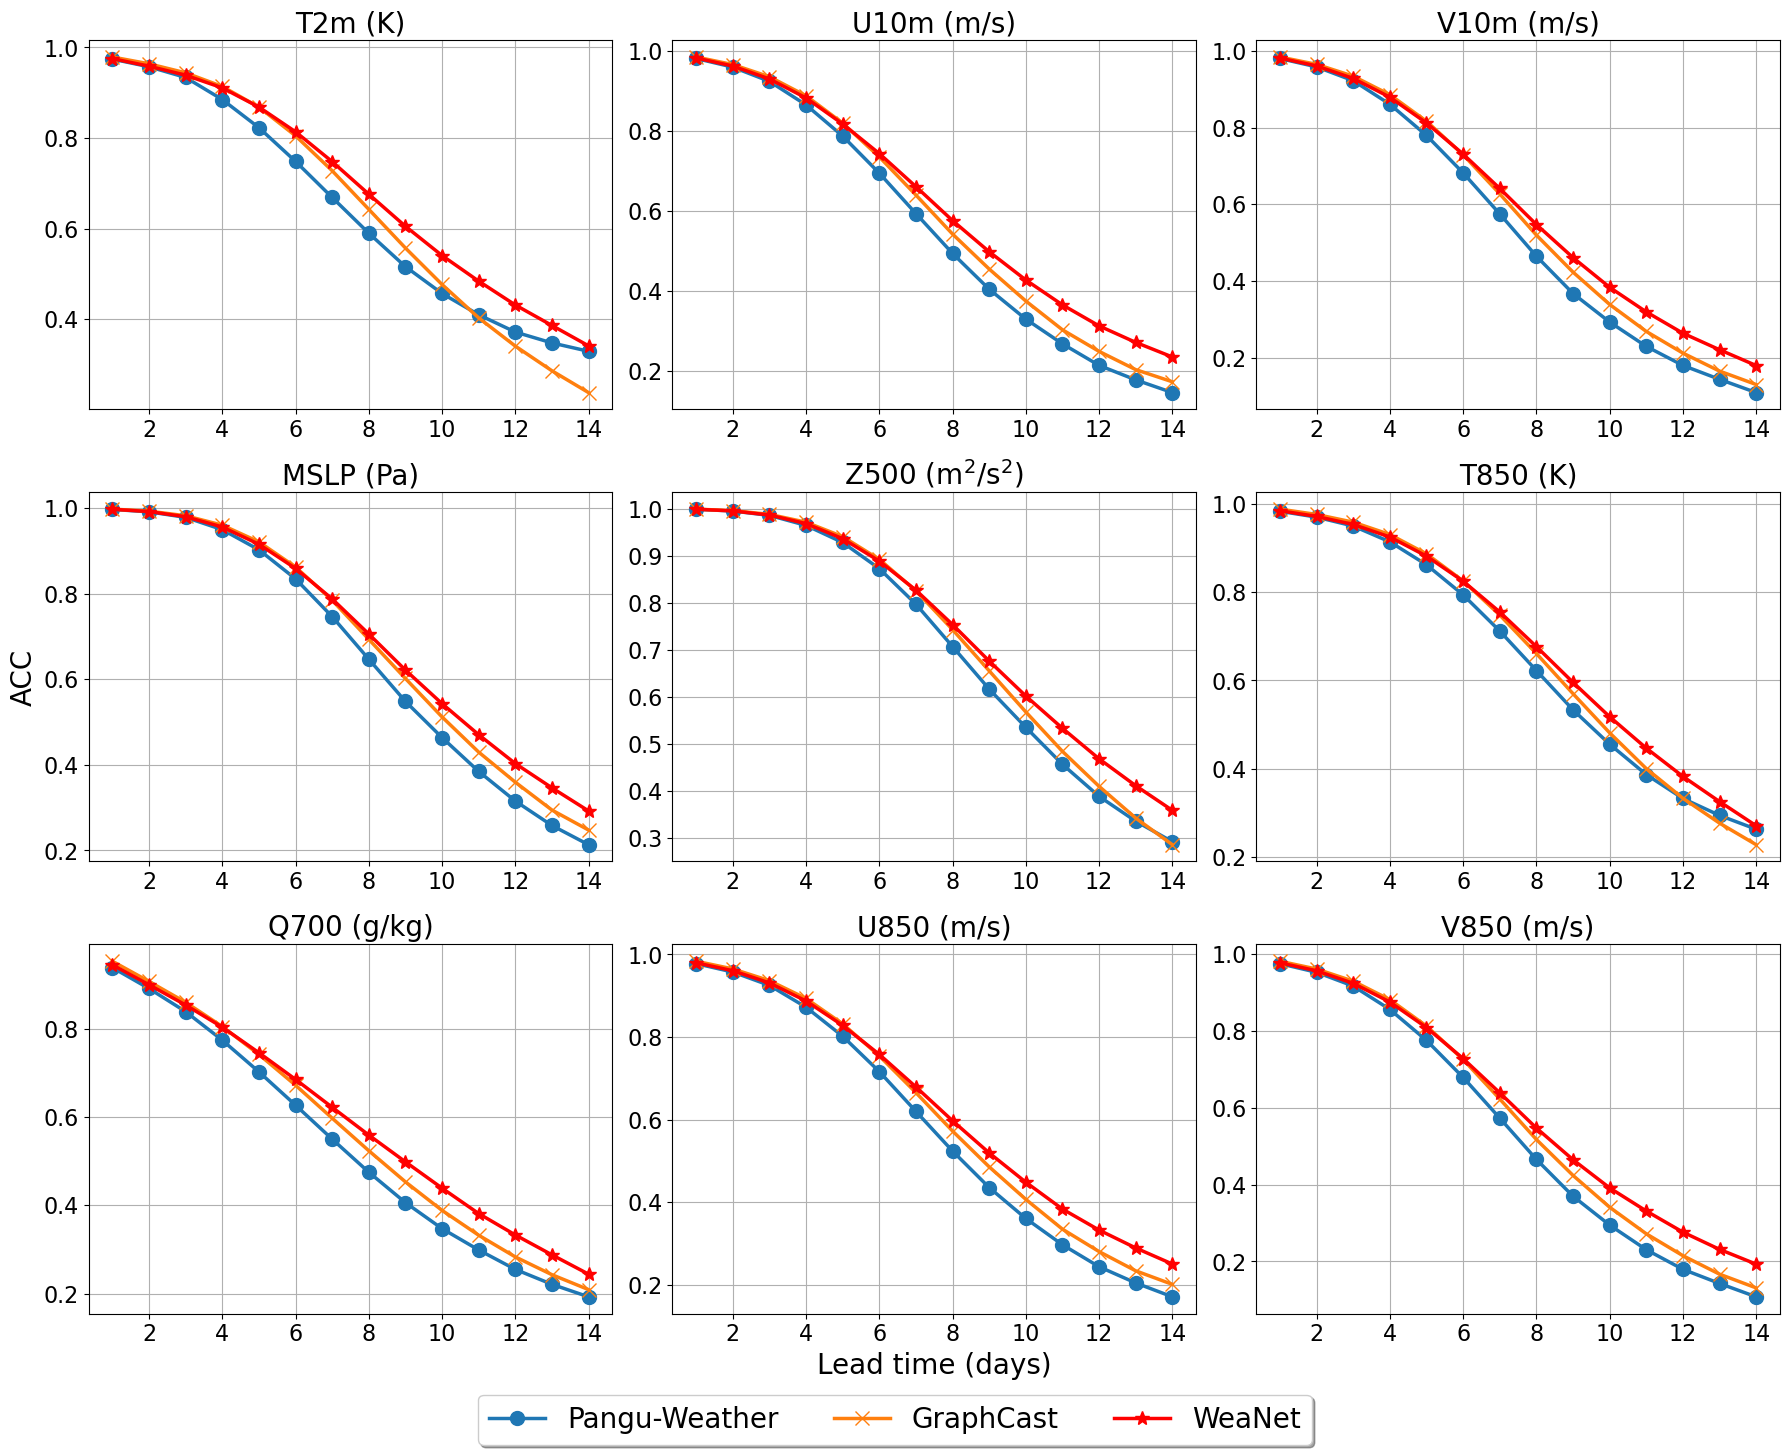

In [41]:
plot_from_json(
    [
        '2m_temperature',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'mean_sea_level_pressure',
        'geopotential_500',
        'temperature_850',
        'specific_humidity_700',
        'u_component_of_wind_850',
        'v_component_of_wind_850',
    ],
    'lat_acc',
    [
        '../pangu_acc.json',
        '../graphcast_acc.json',
        '../Stormer_acc.json',
    ],
    [
        "Pangu-Weather",
        "GraphCast",
        "Stormer"
    ],
    lead_time_list=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336],
    n_cols=3,
    figsize=(18,14),
    filename='acc_full.pdf',
)